# Segmenting and Clustering Neighbourhoods in Toronto


### Section 1: Getting the Boroughs

In [244]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import geocoder
from typing import Tuple
from geopy.geocoders import Nominatim
import folium
import json
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors
pd.set_option('display.max_columns', None)

In [179]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [180]:
html_text=requests.get(url).text

In [181]:
df=pd.read_html(html_text,match='Postal Code')[0]

In [182]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [183]:
df[(df['Borough']=='Not assigned') ^ (df['Neighborhood'].isna())]

,Postal Code,Borough,Neighborhood


Since there are no postal codes that only have a borough or only have a neighbourhood, there is no need to mirror any boroughs onto the neighbourhood. 

In [184]:
# Drop postal codes without assigned boroughs
df=df.drop(df[df['Borough']=='Not assigned'].index)
df.reset_index(drop=True,inplace=True)

In [185]:
df.shape

(103, 3)

### End of Section 1


### Section 2: Getting Latitude and Longitude

In [186]:
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [187]:
def get_coords(postal_code:str) -> Tuple[float,float]:
    while True:
        g=geocoder.google(f'{postal_code}, Toronto, Ontario')
        if g.latlng:
            return g.latlng
        print(g.latlng)

In [188]:
# get_coords('M3A')
g=geocoder.google(f'M3A, Toronto, Ontario')
g

<[REQUEST_DENIED] Google - Geocode [empty]>

Geocoder now requires an API key, which we obviously don't have. We'll use the downloaded coordinate set. 

In [189]:
postal_df=pd.read_csv('Geospatial_Coordinates.csv')
postal_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [190]:
df=df.merge(postal_df,on='Postal Code')
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### End of Section 2

### Section 3: Exploring the Data

In [89]:
address='Toronto, Ontario, Canada'
geolocator=Nominatim(user_agent='toronto_explorer')
location=geolocator.geocode(address)
latitude,longitude=location.latitude,location.longitude
latitude,longitude

(43.6534817, -79.3839347)

In [94]:
map_toronto=folium.Map(location=[latitude,longitude],zoom_start=10)
for lat,lng,label in zip(df['Latitude'],df['Longitude'],df['Neighborhood']):
    label=folium.Popup(label)
    folium.CircleMarker([lat,lng],
                       radius=5,
                       popup=label,
                       color='blue',
                       fill=True,
                       fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)
map_toronto

In [103]:
with open('credentials.json','r') as f:
    secret_info=json.load(f)
CLIENT_ID=secret_info['CLIENT_ID']
CLIENT_SECRET=secret_info['CLIENT_SECRET']
VERSION=secret_info['VERSION']

In [104]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [170]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Ri

In [171]:
print(toronto_venues.shape)
toronto_venues.head()

(2116, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [172]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
...,...,...,...,...,...,...
"Wexford, Maryvale",7,7,7,7,7,7
Willowdale,39,39,39,39,39,39
Woburn,4,4,4,4,4,4


In [173]:
print(f'There are {len(toronto_venues["Venue Category"].unique())} unique categories.')

There are 272 unique categories.


In [174]:
toronto_onehot=pd.get_dummies(toronto_venues['Venue Category'])
toronto_onehot=toronto_venues[['Neighborhood']].join(toronto_onehot,lsuffix=' Name')
toronto_onehot.head()

,Neighborhood Name,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [175]:
toronto_grouped=toronto_onehot.groupby('Neighborhood Name').mean()
toronto_grouped.head()
# temp_neighbor

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Neighborhood Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [176]:
toronto_grouped.shape

(93, 272)

In [200]:
columns=['Neighborhood']
endings=['st','nd','rd','th']
for ind in range(10):
    columns.append(f'{ind+1}{endings[min(ind,3)]} Most Common Venue')
# columns
toronto_venues_sorted=pd.DataFrame(columns=columns)
for idx,row in enumerate(toronto_grouped.iterrows()):
    toronto_venues_sorted.loc[idx,'Neighborhood']=row[0]
    toronto_venues_sorted.iloc[idx,1:]=row[1].sort_values(ascending=False).index.values[0:10]
toronto_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Clothing Store,Latin American Restaurant,Breakfast Spot,Lounge,Skating Rink,Fabric Shop,Event Space,Ethiopian Restaurant,Electronics Store,Diner
1,"Alderwood, Long Branch",Pizza Place,Gym,Skating Rink,Coffee Shop,Pharmacy,Pub,Sandwich Place,Dog Run,Dim Sum Restaurant,Diner
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Frozen Yogurt Shop,Sandwich Place,Bridal Shop,Restaurant,Diner,Deli / Bodega,Supermarket,Sushi Restaurant
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,"Bedford Park, Lawrence Manor East",Restaurant,Sandwich Place,Italian Restaurant,Thai Restaurant,Coffee Shop,Liquor Store,Juice Bar,Pub,Sushi Restaurant,Butcher


In [214]:
toronto_grouped_clustering=toronto_grouped.reset_index().drop('Neighborhood Name',axis=1)
score_results=[]
sil_results=[]
for i in range(2,20):
    kmeans=KMeans(n_clusters=i).fit(toronto_grouped_clustering)
    results.append(kmeans.score(toronto_grouped_clustering))
    sil_results.append(silhouette_score(toronto_grouped_clustering,kmeans.labels_))
    

[-16.95048343923596, -15.14129377281766, -14.169743363878164, -13.243891244770449, -12.294547029853254, -11.476984829718084, -11.04498335041947, -10.282762329558905, -10.035749313624603, -9.76504435251762, -9.124973853127651, -8.764660918058365, -8.359161088926678, -7.9390479793777295, -7.8596266338906275, -7.49634714533485, -7.290393478538673, -6.885844375570411, -6.7593418488767165, -15.146591712249615, -14.276992946817517, -13.172174527016585, -12.909981049994657, -11.568866793008999, -11.107217244960307, -10.81239049053993, -9.75468510036266, -9.346977268172955, -8.963028299867716, -8.734187619534634, -8.453439328094195, -8.132948603012727, -7.760247016457436, -7.420090939654958, -7.138259833954695, -6.97483004679071, -6.656906427998321]


[ 2  4  3  9  6  7 12  8 13 10 11  5 15 18 19 16 17 14]


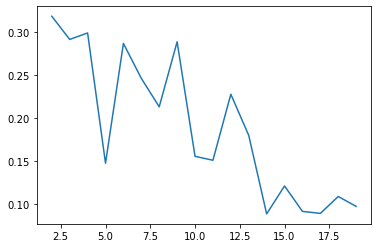

In [224]:
print((np.argsort(sil_results)+2)[::-1])
plt.plot(list(range(2,20)),sil_results)
# Choose k=4

In [249]:
k=9

In [250]:
kmeans=KMeans(n_clusters=k).fit(toronto_grouped_clustering)

In [254]:
toronto_merged=df.merge(pd.DataFrame(kmeans.labels_,columns=['Cluster']),left_index=True,right_index=True).merge(toronto_venues_sorted,on='Neighborhood')
toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1,Park,Food & Drink Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Farmers Market
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Hockey Arena,Coffee Shop,French Restaurant,Portuguese Restaurant,Intersection,Financial or Legal Service,Electronics Store,Eastern European Restaurant,Drugstore,Dim Sum Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Park,Bakery,Breakfast Spot,Café,Pub,Theater,Yoga Studio,Ice Cream Shop,Electronics Store
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,Accessories Store,Gift Shop,Boutique,Event Space,Miscellaneous Shop,Clothing Store,Coffee Shop,Furniture / Home Store,Vietnamese Restaurant,Cosmetics Shop
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Yoga Studio,Bar,Beer Bar,Sandwich Place,Burrito Place,Café,College Auditorium,Park


In [252]:
toronto_merged['Cluster'].unique()

array([1, 4, 7, 0, 3, 6, 8, 5, 2])

In [255]:
map_cluster=folium.Map(location=[latitude,longitude],zoom_start=10)

colors_arr=list(map(colors.rgb2hex,cm.Spectral(np.linspace(0,1,k))))
for row in toronto_merged.iterrows():
    r=row[1]
    label=folium.Popup(f'{r["Neighborhood"]} - Cluster {r["Cluster"]+1}')
    folium.CircleMarker(
        [r['Latitude'],r['Longitude']],
        radius=5,
        popup=label,
        color=colors_arr[r["Cluster"]],
        fill=True,
        fill_color=colors_arr[r["Cluster"]],
        fill_opacity=0.7
    ).add_to(map_cluster)
map_cluster